{{ badge }}

# Radial distribution function

We calculate the radial distribution function (and other gfunctions).

In [27]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
try:
    import MDAnalysis
except ModuleNotFoundError:
    !conda install --yes --prefix {sys.prefix} MDAnalysis
    import MDAnalysis

The following functions are imported from out newanalysis extension:

In [3]:
try:
    from newanalysis.gfunction import RDF
    from newanalysis.helpers import dipByResidue
    from newanalysis.functions import atomsPerResidue, residueFirstAtom
except ModuleNotFoundError as e:
    print("Install newanalysis fist.")
    print("Go to the newanalysis_source folder and run:")
    print("conda activate newanalysis-dev")
    print("pip install .")
    raise(e)

## Preprocessing

Next we create our MDAnalysis Universe:

In [5]:
base='../../test_cases/data/1mq_swm4_equilibrium/'
psf=base+'mqs0_swm4_1000.psf'
#Check PSF:
if np.array_equal(MDAnalysis.Universe(psf).atoms.masses, MDAnalysis.Universe(psf).atoms.masses.astype(bool)):
    print("Used wrong PSF format (masses unreadable!)")
    sys.exit()

u=MDAnalysis.Universe(psf,base+"1mq_swm4.dcd")

skip=20
#dt=round(u.trajectory.dt,4)

#n = int(u.trajectory.n_frames/skip)
#if u.trajectory.n_frames%skip != 0:
#    n+=1

Now we do the selections

In [6]:
sel_solute=u.select_atoms("resname MQS0")
sel=u.select_atoms("resname SWM4")

nsolute=1
nwat = sel.n_residues

## Use the RDF class

In [15]:
histo_min=0.0
histo_dx=0.05
histo_invdx=1.0/histo_dx
histo_max=20.0
boxl = np.float64(round(u.coord.dimensions[0],4))

sol_wat = RDF(["all"],histo_min,histo_max,histo_dx,nsolute,nwat,nsolute,nwat,boxl)
#could also specify a certain one:
sol_wat_000 = RDF(["000"],histo_min,histo_max,histo_dx,nsolute,nwat,nsolute,nwat,boxl) #rdf
#include the picture with the different functions!

some more needed variables

In [16]:
charge_solute=sel_solute.charges
charge_wat=sel.charges

apr_solute = atomsPerResidue(sel_solute)
rfa_solute = residueFirstAtom(sel_solute)
apr_wat = atomsPerResidue(sel)
rfa_wat = residueFirstAtom(sel)

    
mass_solute=sel_solute.masses
mass_wat=sel.masses

Loop throguh the trajectory and get the center of masses

In [17]:
start=time.time()
print("")

for ts in u.trajectory[::skip]:
    print("\033[1AFrame %d of %d" % (ts.frame,u.trajectory.n_frames), "\tElapsed time: %.2f hours" % ((time.time()-start)/3600))
    
    # efficiently calculate center-of-mass coordinates and dipole moments
    coor_wat = np.ascontiguousarray(sel.positions,dtype='double')
    coor_solute = np.ascontiguousarray(sel_solute.positions,dtype='double')
    com_wat=sel.center_of_mass(compound='residues')
    com_solute=sel_solute.center_of_mass(compound='residues')
    dip_wat=dipByResidue(coor_wat,charge_wat,mass_wat,nwat,apr_wat,rfa_wat,com_wat)
    dip_solute=dipByResidue(coor_solute,charge_solute,mass_solute,nsolute,apr_solute,rfa_solute,com_solute)

    #Alternatively:
#    com_wat  = centerOfMassByResidue(sel,coor=coor_wat,masses=mass_wat,apr=apr_wat,rfa=rfa_wat)
#    com_solute  = centerOfMassByResidue(sel_solute,coor=coor_solute,masses=mass_solute,apr=apr_solute,rfa=rfa_solute)
#    dip_wat= dipoleMomentByResidue(sel,coor=coor_wat,charges=charge_wat,masses=mass_wat,com=com_wat,apr=apr_wat,rfa=rfa_wat)
#    dip_solute=dipoleMomentByResidue(sel_solute,coor=coor_solute,charges=charge_solute,masses=mass_solute,com=com_solute,apr=apr_solute,rfa=rfa_solute)

    sol_wat.calcFrame(com_solute,com_wat,dip_solute,dip_wat)

print("Passed time: ",time.time()-start)

Path("output").mkdir(parents=True, exist_ok=True)
sol_wat.write("output/rdf")


Frame 0 of 1000 	Elapsed time: 0.00 hours
Frame 20 of 1000 	Elapsed time: 0.00 hours
Frame 40 of 1000 	Elapsed time: 0.00 hours
Frame 60 of 1000 	Elapsed time: 0.00 hours
Frame 80 of 1000 	Elapsed time: 0.00 hours
Frame 100 of 1000 	Elapsed time: 0.00 hours
Frame 120 of 1000 	Elapsed time: 0.00 hours
Frame 140 of 1000 	Elapsed time: 0.00 hours
Frame 160 of 1000 	Elapsed time: 0.00 hours
Frame 180 of 1000 	Elapsed time: 0.00 hours
Frame 200 of 1000 	Elapsed time: 0.00 hours
Frame 220 of 1000 	Elapsed time: 0.00 hours
Frame 240 of 1000 	Elapsed time: 0.00 hours
Frame 260 of 1000 	Elapsed time: 0.00 hours
Frame 280 of 1000 	Elapsed time: 0.00 hours
Frame 300 of 1000 	Elapsed time: 0.00 hours
Frame 320 of 1000 	Elapsed time: 0.00 hours
Frame 340 of 1000 	Elapsed time: 0.00 hours
Frame 360 of 1000 	Elapsed time: 0.00 hours
Frame 380 of 1000 	Elapsed time: 0.00 hours
Frame 400 of 1000 	Elapsed time: 0.00 hours
Frame 420 of 1000 	Elapsed time: 0.00 hours
Frame 440 of 1000 	Elapsed time: 0.00

## Plot the results

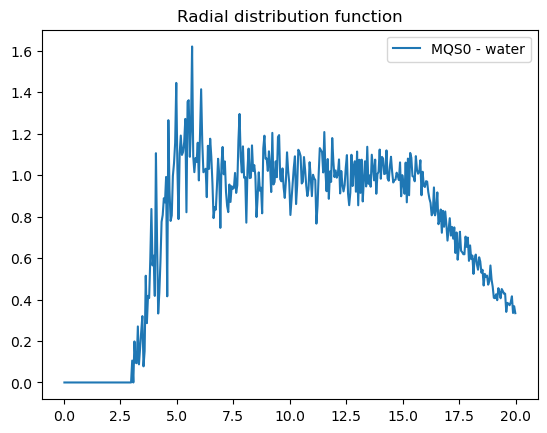

In [19]:
x,y = np.genfromtxt("output/rdf_g000.dat", unpack=True)

plt.title("Radial distribution function")
plt.plot(x,y, label="MQS0 - water")
plt.legend();

**Cleanup**

In [26]:
for file in glob.glob("output/rdf*"):
    Path(file).unlink() #remove files